## Higher Fidelity Graph States
In this notebook, we will prepare quantum circuits for a 7-qubit graph state and estimate the fidelity through stabilizer measurements using Qiskit. In this example, we use the CTMP method of error mitigation [1] and repeat the graph state measurement 16 times to find statistical error bars.

**To Do:
Modify the graph state preparation circuit or use your own methods of error mitigation to improve the graph state fidelity.**


[1] S. Bravyi, S. Sheldon, A. Kandala, D.C. McKay, J.M. Gambetta, Mitigating measurement errors in multi-qubit experiments, [arXiv:2006.14044](https://arxiv.org/abs/2006.14044) (2020).

## Imports

Begin by importing the necessary packages and defining the functions we will need for the stabilizer measurements.

In [1]:
import typing as ty
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for noisy simulation
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.utils import insert_noise

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

# Other imports
import numpy as np

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In order to run the circuits, first load the backend `ibmq_casablanca` from your account using the `IBMQ` provider. You will receive access to `ibm-q-community/ibmquantumawards/open-science` after registering for the Open Science Prize.

In [2]:
# Load IBMQ Account data
from qiskit import IBMQ
IBMQ.load_account()

# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-france', group='univ-montpellier', project='default')
backend = provider.get_backend('ibmq_casablanca')
properties = backend.properties()

## Circuits of interest

We are interested in checking the error we get from several circuits. Here is a description of each.

### Empty circuit

This circuit is here to check the effectiveness of the measurement error mitigation scheme. We are expecting a near-0 error.

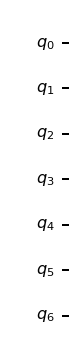

In [3]:
def empty_circuit(qubits=None) -> QuantumCircuit:
    if qubits is None:
        qubits = list(range(7))
    label = ""
    if qubits:
        label = "_" + "-".join(map(str, qubits))
    circ = QuantumCircuit(7, name=f"empty_circuit{label}")
    return circ

circuit = empty_circuit()
circuit.draw(output="mpl")

### Empty circuit with delays

The next circuit of interest is theoretically the same as the first one, but we include some delay in order to let the qubits suffer from decoherence.
The circuit we have right now is $7744$ dt without the measurements, so we will use this as a delay duration.

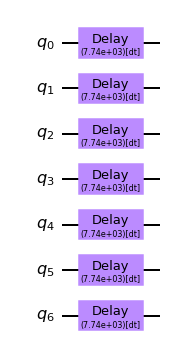

In [4]:
def empty_circuit_delay(delay_dt: int, qubits=None) -> QuantumCircuit:
    if qubits is None:
        qubits = list(range(7))
    label = ""
    if qubits:
        label = "_" + "-".join(map(str, qubits))
    circ = QuantumCircuit(7, name=f"empty_circuit_delayed{label}")
    circ.delay(delay_dt, qarg=qubits)
    return circ

delay_graph_state = 7744
circuit = empty_circuit_delay(delay_graph_state)
circuit.draw(output="mpl")

### Hadamard initialised circuit

We also want to know what is the impact of decoherence on excited states. As we have a quantum state that is initialised with Hadamard gates, we try this with Hadamard gates at the beginning.

To do so, we first submit a circuit without any delay to have it as a comparison point and then we test the same circuit with delays.

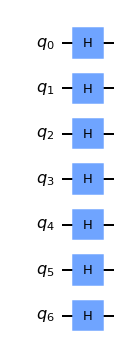

In [5]:
def hadamard_circuit(qubits=None) -> QuantumCircuit:
    if qubits is None:
        qubits = list(range(7))
    label = ""
    if qubits:
        label = "_" + "-".join(map(str, qubits))
    circ = QuantumCircuit(7, name=f"hadamard_initialised{label}")
    circ.h(qubits)
    return circ

circuit = hadamard_circuit()
circuit.draw(output="mpl")

### Hadamard initialised circuit with delay

The Hadamard-initialised circuit, but this time with a delay included.

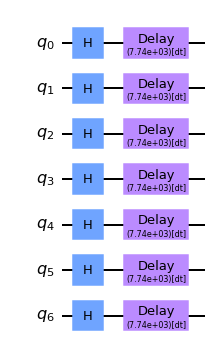

In [6]:
def hadamard_circuit_delay(delay_dt: int, qubits=None) -> QuantumCircuit:
    if qubits is None:
        qubits = list(range(7))
    label = ""
    if qubits:
        label = "_" + "-".join(map(str, qubits))
    circ = QuantumCircuit(7, name=f"hadamard_initialised_delayed{label}")
    circ.h(qubits)
    circ.delay(delay_dt, qarg=qubits)
    return circ

circuit = hadamard_circuit_delay(delay_graph_state)
circuit.draw(output="mpl")

### Bell-state circuit 

It turns out the graph-state circuit, once simplified, is composed of multiple applications of the well-known circuit that initialise a Bell-state. In order to spot any discrepancies in the error rates of each CNOT, we want to check how precisely we can create a Bell state on each hardware-link.

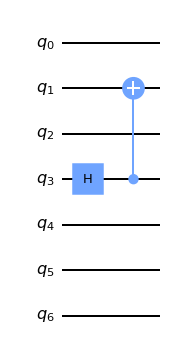

In [7]:
def bell_state_circuit(ctrl: int, trgt: int) -> QuantumCircuit:
    circ = QuantumCircuit(7, name=f"bell_state_circuit_{ctrl}_{trgt}")
    circ.h(ctrl)
    circ.cx(ctrl, trgt)
    return circ

circuit = bell_state_circuit(3, 1)
circuit.draw(output="mpl")

## Build and execution of the circuits

### Build

In order to have the data with and without measurement mitigation, we should submit some calibration circuits to perform measurement mitigation afterwards.

In [8]:
backend = QasmSimulator.from_backend(provider.get_backend('ibmq_casablanca'))
#backend = StatevectorSimulator()

In [9]:
num_qubits = backend.configuration().n_qubits
#labels = ['0000000', 
#          '0000011', 
#          '0000101', '0000110', # Added
#          '0001001', '0001010', '0001100', 
#          '0010001', '0010010', '0010100', '0011000', 
#          '0100001', '0100010', '0100100', '0101000', '0110000', 
#          '1000001', '1000010', '1000100', '1001000', '1010000', '1100000', 
#          '1111111']
#meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(num_qubits, labels=labels)

We generate a list of all the circuits that should be tomographied along with the qubits they act on.

In [10]:
from osp.hardware import get_native_coupling_map
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

empty_circuits =            [empty_circuit([q])                             for q in range(7)]
empty_circuits_delayed =    [empty_circuit_delay(delay_graph_state, [q])    for q in range(7)]
hadamard_circuits =         [hadamard_circuit([q])                          for q in range(7)]
hadamard_circuits_delayed = [hadamard_circuit_delay(delay_graph_state, [q]) for q in range(7)]
bell_state_circuits = [bell_state_circuit(ctrl, trgt)                       for ctrl, trgt in get_native_coupling_map(backend)]

original_circuits = (
    empty_circuits + empty_circuits_delayed + hadamard_circuits 
    + hadamard_circuits_delayed + bell_state_circuits
)
tomography_circuits = [
    state_tomography_circuits(circ, [q]) 
    for l in [empty_circuits, empty_circuits_delayed, hadamard_circuits, hadamard_circuits_delayed]
    for q, circ in enumerate(l)
] + [
    state_tomography_circuits(circ, [ctrl, trgt])
    for circ, (ctrl, trgt) in zip(bell_state_circuits, get_native_coupling_map(backend))
]

qubits_acted_on = [[i] for j in range(4) for i in range(7)] + list(map(list, get_native_coupling_map(backend)))
assert len(qubits_acted_on) == len(tomography_circuits)
assert len(tomography_circuits) == len(original_circuits)

### Execution
Then, we execute the complete measurement error mitigation calibration circuits.

In [11]:
#job_mit_backend = execute(
#    meas_cal_circuits, 
#    backend, 
#    shots=8192, 
#    initial_layout=[0,1,2,3,4,5,6],
#    job_share_level="hub",
#)
#job_mit_backend = backend.retrieve_job("6033b1aed7048739d1e15256")
#print(job_mit_backend.job_id())

We also execute the other circuits by using quantum tomography.

In [13]:
N = 2**2

tomography_jobs = [
#    backend.retrieve_job(job_id)
#    for job_id in [
#        "603633abb3ef8d755c801e4e",
#        "603633b912a3c0306d7d2df6",
#        "603633c701239358a17d513d",
#        "603633d38d07a26bbd950eb8",
#        "603633e2a485b8c57c40b6fb",
#        "603633f2d09b685ae107d6b4",
#        "60363401a1a086343eea20ce",
#        "6036341da1a086da51ea20d0",
#        "6036342ea485b81be640b6fd",
#        "6036343b12a3c037fe7d2dfe",
#        "60363452c11a64dd85a2715f",
#        "6036345da8b0d52435824cd7",
#        "60363468a485b867cd40b6ff",
#        "60363475a485b8753f40b700",
#        "603634808d07a243ba950ec0",
#        "60363491a1a0863ad5ea20d8",
#        "6036349ea8b0d50e40824cd9",
#        "603634aa2b570e96be08af17",
#        "603634b72b570edc3408af18",
#        "603634c312a3c040867d2e02",
#        "603634d0a1a08615adea20db",
#        "603634dbd09b68e23007d6bc",
#        "603634e9a8b0d54874824cdc",
#        "603634f612a3c060ca7d2e03",
#        "60363503b3ef8d6f59801e5b",
#        "60363510c11a6436fea27165",
#        "6036351e2b570e634708af1c",
#        "60363529d09b68f7f507d6bf",
#        "60363535c11a645f36a27167",
#        "6036354112a3c078197d2e08",
#        "6036354da1a08673a0ea20df",
#        "60363562a1a086d6a6ea20e0",
#        "60363574a1a086c046ea20e4",
#        "60363583b3ef8d6e33801e5e",
#    ]
    #execute(
    #    tomo_circs,
    #    backend,
    #    shots=8192,
    #    initial_layout=[0,1,2,3,4,5,6],
    #    job_share_level="hub",
    #)
    #for tomo_circs in tomography_circuits
]

In [14]:
for j in tomography_jobs:
    print(j.job_id())

603633abb3ef8d755c801e4e
603633b912a3c0306d7d2df6
603633c701239358a17d513d
603633d38d07a26bbd950eb8
603633e2a485b8c57c40b6fb
603633f2d09b685ae107d6b4
60363401a1a086343eea20ce
6036341da1a086da51ea20d0
6036342ea485b81be640b6fd
6036343b12a3c037fe7d2dfe
60363452c11a64dd85a2715f
6036345da8b0d52435824cd7
60363468a485b867cd40b6ff
60363475a485b8753f40b700
603634808d07a243ba950ec0
60363491a1a0863ad5ea20d8
6036349ea8b0d50e40824cd9
603634aa2b570e96be08af17
603634b72b570edc3408af18
603634c312a3c040867d2e02
603634d0a1a08615adea20db
603634dbd09b68e23007d6bc
603634e9a8b0d54874824cdc
603634f612a3c060ca7d2e03
60363503b3ef8d6f59801e5b
60363510c11a6436fea27165
6036351e2b570e634708af1c
60363529d09b68f7f507d6bf
60363535c11a645f36a27167
6036354112a3c078197d2e08
6036354da1a08673a0ea20df
60363562a1a086d6a6ea20e0
60363574a1a086c046ea20e4
60363583b3ef8d6e33801e5e


## Result post-processing

First create the complete measure map mitigator and provide an helper function to get a partial mitigator from the full one.

In [15]:
#result_mit = job_mit_backend.result()
#mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit, metadata).fit()
#mitigators = {
#    {0, 1, 2, 3, 4, 5, 6}: mitigator_backend,
#}

#def get_mitigator(qubits):
#    qubits = set(qubits)
#    if qubits not in mitigators:
#        mitigators[qubits] = mitigator_backend.subset_fitter(list(qubits))
#    return mitigators[qubits]

Then create a function to compute and print the expectation value and the standard deviation of the measurement, either using a mitigator or not using any.

In [16]:
from qiskit import ClassicalRegister

perfect_simulator = StatevectorSimulator()

# From https://scicomp.stackexchange.com/questions/30052/calculate-partial-trace-of-an-outer-product-in-python
def ptrace_outer(u, keep, optimize=False):
    """Calculate the partial trace of an outer product

    ρ_a = Tr_b(|u><u|)

    Parameters
    ----------
    u : array
        Vector to use for outer product
    keep : array
        An array of indices of the spaces to keep after
        being traced. For instance, if the space is
        A x B x C x D and we want to trace out B and D,
        keep = [0,2]

    Returns
    -------
    ρ_a : 2D array
        Traced matrix
    """
    keep = np.asarray(keep)
    Ndim = int(np.log2(u.size))
    dims = 2 * np.ones((Ndim,), dtype=np.int)
    Nkeep = np.prod(dims[keep])

    idx1 = [i for i in range(Ndim)]
    idx2 = [Ndim+i if i in keep else i for i in range(Ndim)]
    u = u.reshape(dims)
    rho_a = np.einsum(u, idx1, u.conj(), idx2, optimize=optimize)
    return rho_a.reshape(Nkeep, Nkeep)


def fidelity(
    original_circuit: QuantumCircuit, 
    tomography_circuits: ty.List[QuantumCircuit],
    tomography_job,
    measured_qubits: ty.List[int],
):
    # Size 2**7
    simulation_result = execute(original_circuit, perfect_simulator).result()
    full_statevector = simulation_result.get_statevector()
    perfect_density_matrix = ptrace_outer(full_statevector, [6 - q for q in measured_qubits])
    
    # Not mitigated
    tomography_results = tomography_job.result()
    tomography_fitter = StateTomographyFitter(tomography_results, tomography_circuits)
    tomography_state = tomography_fitter.fit()
    nomit_fidelity = qi.state_fidelity(perfect_density_matrix, tomography_state)
    
    # Mitigated
    #mitigator = get_mitigator(measured_qubits)
    #mitigated_tomography_results = tomography_job.result()
    #tomography_fitter = StateTomographyFitter(tomography_results, tomography_circuits)
    #tomography_state = tomography_fitter.fit()
    #nomit_fidelity = qi.state_fidelity(perfect_quantum_state, tomography_state)
    
    return nomit_fidelity

In [17]:
for original_circ, tomography_circs, tomography_job, measured_qubits in zip(
    original_circuits, 
    tomography_circuits, 
    tomography_jobs, 
    qubits_acted_on
):
    state_fidelity = fidelity(original_circ, tomography_circs, tomography_job, measured_qubits)
    print(f"Measured fidelity for '{original_circ.name}': {state_fidelity:.3f}")

Measured fidelity for 'empty_circuit_0': 0.941
Measured fidelity for 'empty_circuit_1': 0.995
Measured fidelity for 'empty_circuit_2': 0.996
Measured fidelity for 'empty_circuit_3': 0.991
Measured fidelity for 'empty_circuit_4': 0.929
Measured fidelity for 'empty_circuit_5': 0.995
Measured fidelity for 'empty_circuit_6': 0.988
Measured fidelity for 'empty_circuit_delayed_0': 0.984
Measured fidelity for 'empty_circuit_delayed_1': 0.993
Measured fidelity for 'empty_circuit_delayed_2': 0.994
Measured fidelity for 'empty_circuit_delayed_3': 0.984
Measured fidelity for 'empty_circuit_delayed_4': 0.937
Measured fidelity for 'empty_circuit_delayed_5': 0.994
Measured fidelity for 'empty_circuit_delayed_6': 0.981
Measured fidelity for 'hadamard_initialised_0': 0.961
Measured fidelity for 'hadamard_initialised_1': 0.995
Measured fidelity for 'hadamard_initialised_2': 0.994
Measured fidelity for 'hadamard_initialised_3': 0.988
Measured fidelity for 'hadamard_initialised_4': 0.925
Measured fidelit

In [23]:
job = tomography_jobs[0]
result = job.result()
experiment_result = result.results[0]
experiment_result.__dict__

{'_metadata': {'memory': False},
 'shots': 8192,
 'success': True,
 'data': ExperimentResultData(counts={'0x0': 3812, '0x1': 4380}),
 'meas_level': 2,
 'header': namespace(clbit_labels=[['c0', 0]],
           creg_sizes=[['c0', 1]],
           global_phase=0.7853981633974483,
           memory_slots=1,
           n_qubits=7,
           name="('X',)",
           qreg_sizes=[['q', 7]],
           qubit_labels=[['q', 0],
                         ['q', 1],
                         ['q', 2],
                         ['q', 3],
                         ['q', 4],
                         ['q', 5],
                         ['q', 6]])}

In [34]:
result.results

[ExperimentResult(shots=8192, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 3812, '0x1': 4380}), header=QobjExperimentHeader(clbit_labels=[['c0', 0]], creg_sizes=[['c0', 1]], global_phase=0.7853981633974483, memory_slots=1, n_qubits=7, name="('X',)", qreg_sizes=[['q', 7]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5], ['q', 6]]), memory=False),
 ExperimentResult(shots=8192, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 3941, '0x1': 4251}), header=QobjExperimentHeader(clbit_labels=[['c0', 0]], creg_sizes=[['c0', 1]], global_phase=0.0, memory_slots=1, n_qubits=7, name="('Y',)", qreg_sizes=[['q', 7]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5], ['q', 6]]), memory=False),
 ExperimentResult(shots=8192, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 7706, '0x1': 486}), header=QobjExperimentHeader(clbit_labels=[['c0', 0]], creg_sizes=[['c0', 1]], global_phase=0.0, memo